In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from fetch_coint_fn import fetch_coint_pairs

## Detect and get params

In [29]:
def calculate_params(series1, series2):
    x_with_const = sm.add_constant(series2)
    model = sm.OLS(series1, x_with_const)
    results = model.fit()
    intercept, beta = results.params
    return intercept, beta

def get_spread(series1, series2, beta):
    spread = series1 - (beta * series2)
    return spread

def get_zscore(spread):
    mean = np.mean(spread)
    std = np.std(spread)
    zscore = (spread - mean) / std
    return zscore

## Backtesting

In [30]:
def get_raw_df(symbol1, symbol2, df1, df2):
    """
    Spread = P1 - beta * P2
    long spread = long P1, short P2
    """
    if len(df1) != len(df2):
        return None

    raw_df = pd.DataFrame()

    raw_df = pd.concat([df1, df2], axis = 1)
    raw_df.columns = [
        "Timestamp", f"Open_{symbol1}", f"High_{symbol1}", f"Low_{symbol1}", f"Close_{symbol1}", f"Volume_{symbol1}", f"Turnover_{symbol1}",
        "Timestamp", f"Open_{symbol2}", f"High_{symbol2}", f"Low_{symbol2}", f"Close_{symbol2}", f"Volume_{symbol2}", f"Turnover_{symbol2}"
        ]
    raw_df = raw_df.loc[:,~raw_df.columns.duplicated()]
    raw_df.set_index("Timestamp", inplace = True)
    raw_df.index = pd.to_datetime(raw_df.index)

    raw_df["beta"] = calculate_params(raw_df[f"Close_{symbol1}"], raw_df[f"Close_{symbol2}"])[1]
    raw_df["spread"] = get_spread(raw_df[f"Close_{symbol1}"], raw_df[f"Close_{symbol2}"], raw_df["beta"])
    Z = get_zscore(raw_df["spread"])

    raw_df["Z_score"] = Z
    raw_df["Entry_long"] = Z < -2
    raw_df["Exit_long"] = Z >= -0.5
    raw_df["Entry_short"] = Z > 2
    raw_df["Exit_short"] = Z <= 0.75

    return raw_df

In [31]:
def backtest(raw_df, symbol1, symbol2, window_start = 0, window_end = None, Spot_fund = 10000, cost = 0.001):
    if raw_df is None:
        return None

    if window_start == 0 and window_end is None:
        testing_data = raw_df.copy()
    else:
        testing_data = raw_df.loc[window_start: window_end].copy()
    
    BS = None
    cols_to_init = [f"Spotsize_{symbol1}", f"Spotsize_{symbol2}", "Profit", "Profitfee", "cumReturn", "Drawdown"]
    testing_data[cols_to_init] = 0.0
    
    for i in range(len(testing_data)):
        if i == len(testing_data) - 1:
            break
        
        Timestamp = testing_data.index[i]
        nextTimestamp = testing_data.index[i + 1]
        if BS is None:
            if testing_data["Entry_long"].iloc[i]:
                BS = "B"
                entry_price1 = testing_data.loc[nextTimestamp, f"Open_{symbol1}"]
                entry_price2 = testing_data.loc[nextTimestamp, f"Open_{symbol2}"]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = (Spot_fund / 2) / testing_data[f"Open_{symbol1}"].iloc[i]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = - (Spot_fund / 2) / testing_data[f"Open_{symbol2}"].iloc[i]

            elif testing_data["Entry_short"].iloc[i]:
                BS = "S"
                entry_price1 = testing_data.loc[nextTimestamp, f"Open_{symbol1}"]
                entry_price2 = testing_data.loc[nextTimestamp, f"Open_{symbol2}"]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = - (Spot_fund / 2) / testing_data[f"Open_{symbol1}"].iloc[i]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = (Spot_fund / 2) / testing_data[f"Open_{symbol2}"].iloc[i]
        
        elif BS in ["B", "S"]:
            testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = testing_data.loc[Timestamp, f"Spotsize_{symbol1}"]
            testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = testing_data.loc[Timestamp, f"Spotsize_{symbol2}"]
            testing_data.loc[Timestamp, "Profit"] = (testing_data.loc[nextTimestamp, f"Open_{symbol1}"] - testing_data.loc[Timestamp, f"Open_{symbol1}"]) * testing_data[f"Spotsize_{symbol1}"].iloc[i] + (testing_data.loc[nextTimestamp, f"Open_{symbol2}"] - testing_data.loc[Timestamp, f"Open_{symbol2}"]) * testing_data[f"Spotsize_{symbol2}"].iloc[i]
            if testing_data["Profit"].iloc[i - 1] == 0 and testing_data["Profit"].iloc[i] != 0:
                cost_amount = abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"]) * entry_price1 * cost + \
                                abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"]) * entry_price2 * cost
                testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profit"] - cost_amount
            else:
                testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profit"]
            
            if (BS == "B" and testing_data[f"Spotsize_{symbol1}"].iloc[i]) or (BS == "S" and testing_data["Exit_short"].iloc[i]):
                BS = None
                exit_price1 = testing_data.loc[nextTimestamp, f"Open_{symbol1}"]
                exit_price2 = testing_data.loc[nextTimestamp, f"Open_{symbol2}"]
                cost_amount = abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"]) * exit_price1 * cost + \
                                abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"]) * exit_price2 * cost
                testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profitfee"] - cost_amount
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = 0
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = 0

    testing_data["cumReturn"] = testing_data["Profitfee"].cumsum()
    peak = testing_data["cumReturn"].cummax()
    testing_data["Drawdown"] = - (testing_data["cumReturn"] - peak) / peak

    return testing_data

In [32]:
def get_performance(df, cost, freq_per_day = 24):
    if df is None:
        return None
    
    performance = {}
    profit_series = df["Profitfee"].dropna()
    negative_profit = profit_series[profit_series < 0]
    positive_profit = profit_series[profit_series > 0]

    performance["totalReturn"] = df["Profit"].sum()
    performance["totalProfitfee"] = df["Profitfee"].sum()
    performance["AnnualizedReturn"] = profit_series.mean() * freq_per_day * 365
    performance["Win Rate"] = len(positive_profit) / len(profit_series) if len(profit_series) != 0 else 0
    performance["SharpeRatio"] = profit_series.mean() / profit_series.std() if profit_series.std() != 0 else np.nan
    performance["SortinoRatio"] = profit_series.mean() / negative_profit.std() if negative_profit.std() != 0 else np.nan
    performance["ProfitFactor"] = positive_profit.sum() / abs(negative_profit.sum()) if abs(negative_profit.sum()) != 0 else np.inf
    performance["MaxDrawdown"] = df["Drawdown"].min()

    return performance

In [33]:
def get_new_main_df(df, symbol1, symbol2):
    new_main_df = df[["Profit", "Profitfee"]].copy()
    new_main_df["Timestamp"] = df.index
    new_main_df["Pairs"] = (symbol1 + " - " + symbol2)
    new_main_df["Pairs"] = new_main_df["Pairs"].astype("category")

    cols = ["Pairs", "Profit", "Profitfee"]
    new_main_df = new_main_df[cols]

    return new_main_df

In [34]:
def get_trade_details(trade_details, testing_df, symbol1, symbol2):
    testing_df.index = pd.to_datetime(testing_df.index)
    entry_time = entry_price1 = entry_price2 = size1 = size2 = None

    for i in range(1, len(testing_df)):
        entry = testing_df[f"Spotsize_{symbol1}"].iloc[i] != 0 and testing_df[f"Spotsize_{symbol1}"].iloc[i - 1] == 0
        exit = testing_df[f"Spotsize_{symbol1}"].iloc[i] == 0 and testing_df[f"Spotsize_{symbol1}"].iloc[i - 1] != 0
        if entry:
            entry_time = testing_df.index[i]
            entry_price1 = testing_df[f"Open_{symbol1}"].iloc[i]
            entry_price2 = testing_df[f"Open_{symbol2}"].iloc[i]
            size1 = testing_df[f"Spotsize_{symbol1}"].iloc[i]
            size2 = testing_df[f"Spotsize_{symbol2}"].iloc[i]

        elif exit:
            exit_time = testing_df.index[i]
            exit_price1 = testing_df[f"Open_{symbol1}"].iloc[i]
            exit_price2 = testing_df[f"Open_{symbol2}"].iloc[i]
            profitfee = testing_df.loc[entry_time: exit_time, "Profitfee"].cumsum().iloc[-1]
            holding_period = exit_time - entry_time

            trade_details.append({
                "Pairs": f"{symbol1} - {symbol2}",
                "Size1": size1,
                "Size2": size2,
                "EntryTime": entry_time,
                "EntryPrice1": entry_price1,
                "EntryPrice2": entry_price2,
                "ExitTime": exit_time,
                "ExitPrice1": exit_price1,
                "ExitPrice2": exit_price2,
                "HoldingPeriod": holding_period,
                "Profitfee": profitfee
            })

    
    return trade_details

In [35]:
def rolling(main_df, train_ratio, n_window, spot_sector_map, spot_folder, cost, focus_indicator = "totalReturn"):
    """
    有時候不能整除，所以可能會多一個window
    """
    total_size = len(main_df)
    test_ratio = 1 - train_ratio
    trade_details = []
    
    window = total_size // (1 + test_ratio * (n_window - 1))
    train_size = int(window * train_ratio)
    test_size = int(window * test_ratio)

    start = 0
    window_num = 0

    while start + train_size + test_size <= total_size:
        print(f"Processing window {window_num + 1}")

        train_results = []
        train = main_df.iloc[start : start + train_size]
        train_start_time = train.index[0]
        train_end_time = train.index[-1]
        print(f"{train_start_time}-{train_end_time}")
        
        # fetch cointegrated pairs by parralel processing(up to 8 workers)
        coint_pairs = fetch_coint_pairs(spot_sector_map, spot_folder, train_start_time, train_end_time, max_workers = 6)
        for pair_data in coint_pairs:
            sector = pair_data["sector"]
            symbol1, symbol2 = pair_data["pair"][0], pair_data["pair"][1]

            df1 = pd.read_csv(f"{spot_folder}/{symbol1}.csv")
            df2 = pd.read_csv(f"{spot_folder}/{symbol2}.csv")
            raw_df = get_raw_df(symbol1, symbol2, df1, df2)
            training_df = backtest(raw_df, symbol1, symbol2, train_start_time, train_end_time)
            if training_df is None:
                continue
            performance = get_performance(training_df, cost)
            train_results.append({
                "sector": sector,
                "pair": (symbol1, symbol2),
                "performance": performance
            })

        sorted_results = sorted(train_results, key = lambda x: x["performance"][focus_indicator], reverse = True)
        sorted_df = pd.DataFrame(sorted_results)
        sorted_df.to_csv("sorted_results.csv")
        best_pair = sorted_results[0]
        symbol1, symbol2 = best_pair["pair"][0], best_pair["pair"][1]

        test = main_df.iloc[start + train_size : start + train_size + test_size]
        testing_start_time = test.index[0]
        testing_end_time = test.index[-1]

        df1 = pd.read_csv(f"{spot_folder}/{symbol1}.csv")
        df2 = pd.read_csv(f"{spot_folder}/{symbol2}.csv")
        raw_df = get_raw_df(symbol1, symbol2, df1, df2)
        testing_df = backtest(raw_df, symbol1, symbol2, testing_start_time, testing_end_time)
        testing_df.to_csv("test.csv")

        performance = get_performance(testing_df, cost)
        new_main_df = get_new_main_df(testing_df, symbol1, symbol2)
        main_df.update(new_main_df)
        trade_details = get_trade_details(trade_details, testing_df, symbol1, symbol2)
        start += test_size
        window_num += 1

    main_df["cumReturn"] = main_df["Profitfee"].cumsum()
    peak = main_df["cumReturn"].cummax()
    try:
        main_df["Drawdown"] = - (main_df["cumReturn"] - peak) / peak
    except:
        main_df["Drawdown"] = 0
        
    return main_df, trade_details

In [36]:
spot_sector = "/Users/xinc./Documents/GitHub/Quant/data/crypto_database/metadata/spot_sector_map.json"
spot_folder = "/Users/xinc./Documents/GitHub/Quant/data/crypto_database/spot"

with open(spot_sector, "r") as f:
    spot_sector_map = json.load(f)

start = "2022-01-01 00:00:00+08:00"
end = "2025-03-30 21:00:00+08:00"
train_interval = 2 # months
test_interval = 1 # months

main_df = pd.DataFrame(index = pd.date_range(start, end, freq = "h"), columns = ["Pairs", "Profit", "Profitfee", "cumReturn", "Drawdown"])
train_size, test_size = train_interval * 30 * 24, test_interval * 30 * 24
window_size = train_size + test_size
train_ratio = train_size / (train_size + test_size)
n_window = (len(main_df) - train_size - test_size) // test_size + 1

In [37]:
print(train_size, test_size, window_size, train_ratio, n_window)

1440 720 2160 0.6666666666666666 37


In [38]:
main_df, trade_details = rolling(main_df, train_ratio, n_window, spot_sector_map, spot_folder, 0.001)
main_df.to_csv("main_df.csv")
trade_details.to_csv("trade_details.csv", index = False)

Processing window 1
2022-01-01 00:00:00+08:00-2022-03-02 17:00:00+08:00


 10%|▉         | 262/2701 [00:26<04:07,  9.84it/s]Process SpawnPoolWorker-79049:

Process SpawnPoolWorker-79050:
Process SpawnPoolWorker-79045:
Process SpawnPoolWorker-79047:
Process SpawnPoolWorker-79048:


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 853, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/xinc./Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/np/82kc955j7g9_6x0dw88zjzw40000gn/T/ipykernel_1582/2750791074.py", line 1, in <module>
    main_df, trade_details = rolling(main_df, train_ratio, n_window, spot_sector_map, spot_folder, 0.001)
  File "/var/folders/np/82kc955j7g9_6x0dw88zjzw40000gn/T/ipykernel_1582/262070604.py", line 26, in rolling
    coint_pairs = fetch_coint_pairs(spot_sector_map, spot_folder, train_start_time, train_end_time, max_workers = 6)
  File "/Users/xinc./Doc

<Axes: >

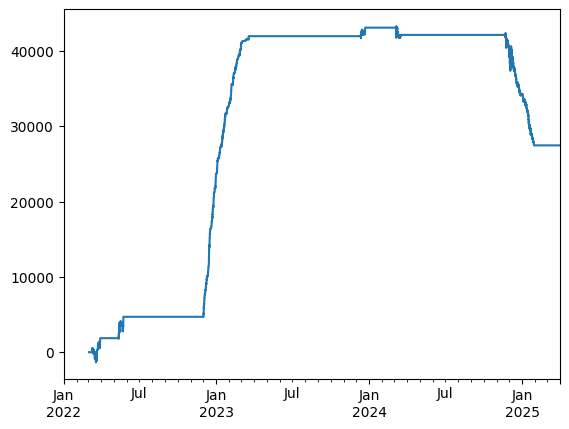

In [ ]:
main_df["cumReturn"].plot()

0


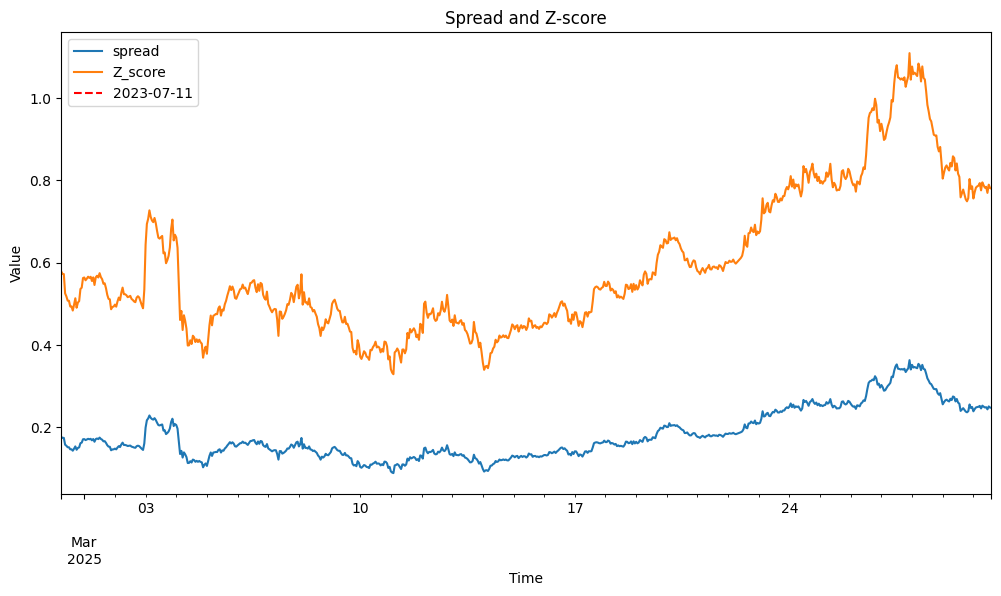

In [ ]:
test = pd.read_csv("test.csv")
test["Timestamp"] = pd.to_datetime(test["Timestamp"])
test.set_index("Timestamp", inplace=True)

print(test["Entry_short"].sum())

ax = test[['spread', "Z_score"]].plot(figsize=(12, 6))

plt.axvline(pd.Timestamp("2023-07-11"), color='red', linestyle='--', label='2023-07-11')

plt.legend()
plt.title("Spread and Z-score")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()